In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

basedatos_df = pd.read_csv('basedatos_modelo_final.csv', sep =';',encoding='utf-8')
basedatos_df.head()

,station_id,cant_unplug_hora,cant_plug_hora,dia,mes,año,dia_semana,hour,Valor_Temp,Valor_Prec,dia_especial
0,1,0,1,1,1,2018,0,4,6.0,0.0,1
1,1,0,1,1,1,2018,0,7,5.0,0.0,1
2,1,2,0,1,1,2018,0,8,5.0,0.0,1
3,1,0,1,1,1,2018,0,9,5.0,0.0,1
4,1,0,8,1,1,2018,0,10,5.0,0.0,1


# Gráficos Estacionalidad para enganches

In [3]:
# --- 1. Cargar el dataset completo ---
try:
    df = pd.read_csv('bdcompleta_usos_bicimad_Final.csv', sep=';')
    print("Dataset 'bdcompleta_usos_bicimad.csv' cargado exitosamente.")
    print(f"Filas iniciales: {df.shape[0]}")
except FileNotFoundError:
    print("Error: 'bdcompleta_usos_bicimad.csv' no encontrado. Por favor, verifica la ruta.")
    exit() # Sale del script si el archivo no se encuentra

# Convertir unplug_hourTime a datetime
df['unplug_hourTime'] = pd.to_datetime(df['unplug_hourTime']) # unplug_hourTime

# --- 2. Eliminar registros con travel_time < 5 minutos para viajes 'circulares' (mismo origen-destino) ---
# Se asume que 'idunplug_station' y 'idplug_station' se refieren a las IDs de las estaciones.
# Travel time está en segundos, 5 minutos = 300 segundos
df_filtered_time = df[
    ~((df['idunplug_station'] == df['idplug_station']) & (df['travel_time'] < 300))
].copy() # Usar .copy() para evitar SettingWithCopyWarning

print(f"Filas después de eliminar viajes < 5min en misma estación: {df_filtered_time.shape[0]}")

# --- 3. Procesar Desenganches (unplug) ---
df_unplug = df_filtered_time[['idunplug_station', 'unplug_hourTime']].copy()
df_unplug.rename(columns={'idunplug_station': 'station_id'}, inplace=True)
df_unplug['event_type'] = 'unplug' # Etiqueta para identificar el evento

# Extraer componentes de tiempo para desenganches
df_unplug['año'] = df_unplug['unplug_hourTime'].dt.year
df_unplug['mes'] = df_unplug['unplug_hourTime'].dt.month
df_unplug['dia'] = df_unplug['unplug_hourTime'].dt.day
df_unplug['dia_semana'] = df_unplug['unplug_hourTime'].dt.dayofweek # Lunes=0, Domingo=6
df_unplug['hour'] = df_unplug['unplug_hourTime'].dt.hour

# --- 4. Procesar Enganches (plug) ---
df_plug = df_filtered_time[['idplug_station', 'unplug_hourTime', 'travel_time']].copy()
df_plug.rename(columns={'idplug_station': 'station_id'}, inplace=True)
df_plug['event_type'] = 'plug' # Etiqueta para identificar el evento

# Calcular plug_hourTime sumando travel_time (en segundos)
df_plug['plug_hourTime'] = df_plug['unplug_hourTime'] + pd.to_timedelta(df_plug['travel_time'], unit='s')

# Filtramos viajes de más de 24 horas (en segundos)
df_plug_filtered_duration = df_plug[df_plug['travel_time'] <= (24 * 3600)].copy() # 24 horas en segundos

# Esto es para la duración del viaje, no la hora del día.
df_plug_filtered_duration['adjusted_travel_time'] = df_plug_filtered_duration['travel_time']
long_travels_mask = (df_plug_filtered_duration['travel_time'] > (2 * 3600)) & (df_plug_filtered_duration['travel_time'] <= (24 * 3600))
df_plug_filtered_duration.loc[long_travels_mask, 'adjusted_travel_time'] = (2 * 3600) # Ajustar a 2 horas

# Recalcular plug_hourTime con el adjusted_travel_time
df_plug_filtered_duration['plug_hourTime'] = df_plug_filtered_duration['unplug_hourTime'] + pd.to_timedelta(df_plug_filtered_duration['adjusted_travel_time'], unit='s')

# Extraer componentes de tiempo para enganches
df_plug_filtered_duration['año'] = df_plug_filtered_duration['plug_hourTime'].dt.year
df_plug_filtered_duration['mes'] = df_plug_filtered_duration['plug_hourTime'].dt.month
df_plug_filtered_duration['dia'] = df_plug_filtered_duration['plug_hourTime'].dt.day
df_plug_filtered_duration['dia_semana'] = df_plug_filtered_duration['plug_hourTime'].dt.dayofweek
df_plug_filtered_duration['hour'] = df_plug_filtered_duration['plug_hourTime'].dt.hour

df_plug = df_plug_filtered_duration.drop(columns=['unplug_hourTime', 'travel_time', 'adjusted_travel_time', 'plug_hourTime']).copy()

print(f"Filas después de procesar enganches y filtrar duraciones: {df_plug.shape[0]}")

# --- 5. Eliminar registros donde station_id es 0 o > 272 en AMBOS datasets ---
df_unplug_filtered_stations = df_unplug[
    (df_unplug['station_id'] > 0) & (df_unplug['station_id'] <= 272)
].copy()

df_plug_filtered_stations = df_plug[
    (df_plug['station_id'] > 0) & (df_plug['station_id'] <= 272)
].copy()

print(f"Filas de desenganches después de filtrar estaciones: {df_unplug_filtered_stations.shape[0]}")
print(f"Filas de enganches después de filtrar estaciones: {df_plug_filtered_stations.shape[0]}")


# --- 6. Consolidar y Calcular Cantidades por Estación, Año, Mes, Día, Hora ---

# Para desenganches
hourly_station_unplug_counts = df_unplug_filtered_stations.groupby(
    ['station_id', 'año', 'mes', 'dia', 'hour']
).size().reset_index(name='cant_unplug_hora')

# Para enganches
hourly_station_plug_counts = df_plug_filtered_stations.groupby(
    ['station_id', 'año', 'mes', 'dia', 'hour']
).size().reset_index(name='cant_plug_hora')

print("\nPrimeras filas de conteos de desenganches por hora y estación:")
print(hourly_station_unplug_counts.head())
print("\nPrimeras filas de conteos de enganches por hora y estación:")
print(hourly_station_plug_counts.head())


# --- 7. Generar Tablas de Promedios por Hora y Mes (con 3 decimales) ---

print("\n--- Promedio de Enganches y Desenganches por HORA del Día (Corregido) ---")
hourly_summary = pd.merge(
    hourly_station_plug_counts.groupby('hour')['cant_plug_hora'].mean().reset_index(),
    hourly_station_unplug_counts.groupby('hour')['cant_unplug_hora'].mean().reset_index(),
    on='hour',
    how='outer'
)
hourly_summary = hourly_summary.rename(columns={
    'cant_plug_hora': 'Promedio_Enganches',
    'cant_unplug_hora': 'Promedio_Desenganches'
})
hourly_summary['Promedio_Enganches'] = hourly_summary['Promedio_Enganches'].round(3)
hourly_summary['Promedio_Desenganches'] = hourly_summary['Promedio_Desenganches'].round(3)
#print(hourly_summary)


print("\n--- Promedio de Enganches y Desenganches por MES del Año (Corregido) ---")
monthly_summary = pd.merge(
    hourly_station_plug_counts.groupby('mes')['cant_plug_hora'].mean().reset_index(),
    hourly_station_unplug_counts.groupby('mes')['cant_unplug_hora'].mean().reset_index(),
    on='mes',
    how='outer'
)
monthly_summary = monthly_summary.rename(columns={
    'cant_plug_hora': 'Promedio_Enganches',
    'cant_unplug_hora': 'Promedio_Desenganches'
})
monthly_summary['Promedio_Enganches'] = monthly_summary['Promedio_Enganches'].round(3)
monthly_summary['Promedio_Desenganches'] = monthly_summary['Promedio_Desenganches'].round(3)
#print(monthly_summary)

# --- OPCIONAL: Generar gráficas con los nuevos promedios ---


Dataset 'bdcompleta_usos_bicimad.csv' cargado exitosamente.
Filas iniciales: 19541580
Filas después de eliminar viajes < 5min en misma estación: 17636889
Filas después de procesar enganches y filtrar duraciones: 17636823
Filas de desenganches después de filtrar estaciones: 17634546
Filas de enganches después de filtrar estaciones: 17633058

Primeras filas de conteos de desenganches por hora y estación:
   station_id   año  mes  dia  hour  cant_unplug_hora
0           1  2018    1    1     8                 2
1           1  2018    1    1    12                 3
2           1  2018    1    1    15                 6
3           1  2018    1    1    16                 3
4           1  2018    1    1    17                 5

Primeras filas de conteos de enganches por hora y estación:
   station_id   año  mes  dia  hour  cant_plug_hora
0           1  2018    1    1     4               1
1           1  2018    1    1     7               1
2           1  2018    1    1     9               1
3


--- Generando Gráficos con datos corregidos ---


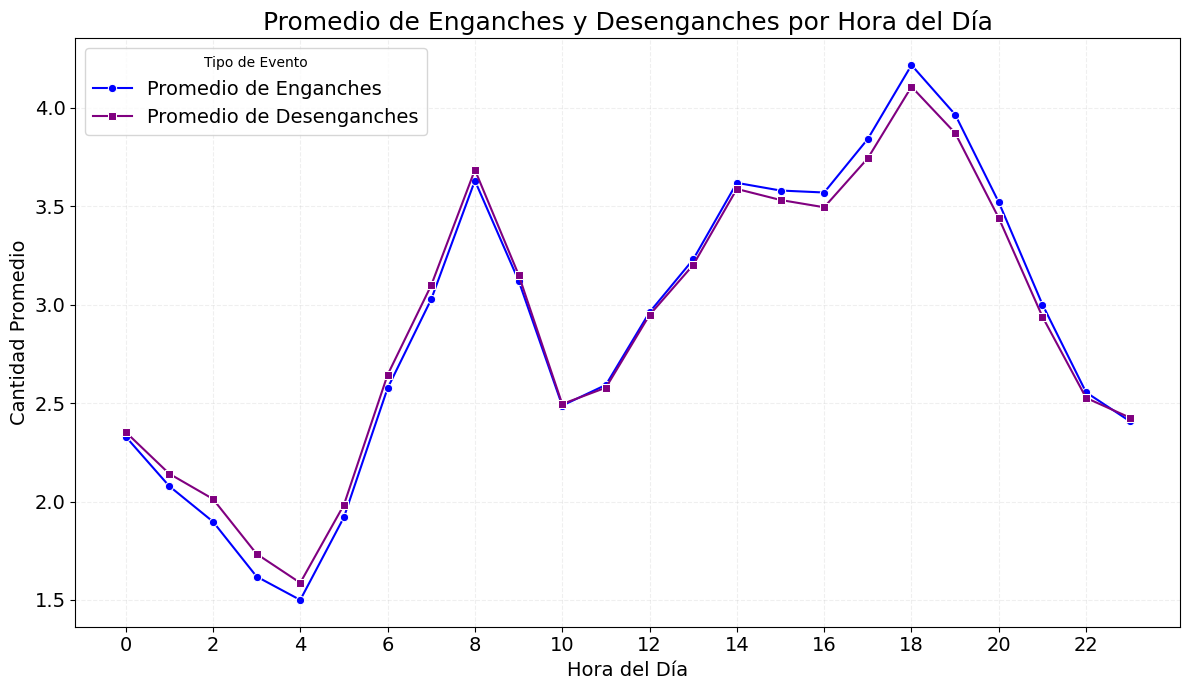

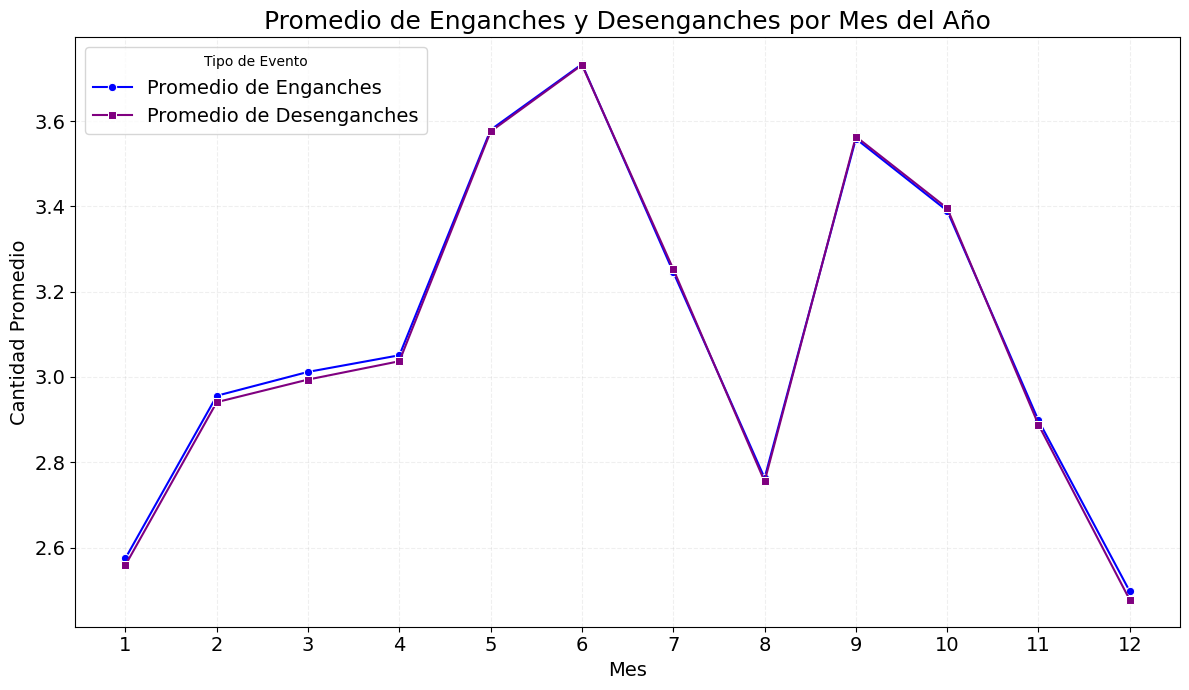

In [4]:

print("\n--- Generando Gráficos con datos corregidos ---")

# Gráfico de Promedio de Enganches y Desenganches por HORA
plt.figure(figsize=(12, 7))
sns.lineplot(x='hour', y='Promedio_Enganches', data=hourly_summary, marker='o', label='Promedio de Enganches', color='blue')
sns.lineplot(x='hour', y='Promedio_Desenganches', data=hourly_summary, marker='s', label='Promedio de Desenganches', color='purple')
plt.title('Promedio de Enganches y Desenganches por Hora del Día', fontsize=18)
plt.xlabel('Hora del Día', fontsize=14)
plt.ylabel('Cantidad Promedio', fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(range(0, 24, 2))
plt.legend(title='Tipo de Evento', loc='upper left', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

# Gráfico de Promedio de Enganches y Desenganches por MES
plt.figure(figsize=(12, 7))
sns.lineplot(x='mes', y='Promedio_Enganches', data=monthly_summary, marker='o', label='Promedio de Enganches', color='blue')
sns.lineplot(x='mes', y='Promedio_Desenganches', data=monthly_summary, marker='s', label='Promedio de Desenganches', color='purple')
plt.title('Promedio de Enganches y Desenganches por Mes del Año', fontsize=18)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Cantidad Promedio', fontsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.xticks(range(1, 13))
plt.legend(title='Tipo de Evento', loc='upper left', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()

Dataset 'bdcompleta_usos_bicimad.csv' cargado para preprocesamiento.
`basedatos_df` ha sido preprocesado y está listo con 'plug_hourTime' y filtros aplicados.

Generando gráfica de Promedio de Enganches Diarios por Estación...
Las 10 estaciones con mayor promedio de enganches diarios:
     idplug_station  daily_plug_count
42             43.0        136.094312
173           175.0        127.209644
56             57.0        126.155462
88             90.0        102.052521
130           132.0         99.460948
133           135.0         96.975490
218           220.0         96.689189
161           163.0         96.689029
206           208.0         96.643449
48             49.0         95.632610


C:\Users\ProjectSupport\AppData\Local\Temp\ipykernel_18808\2474540722.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


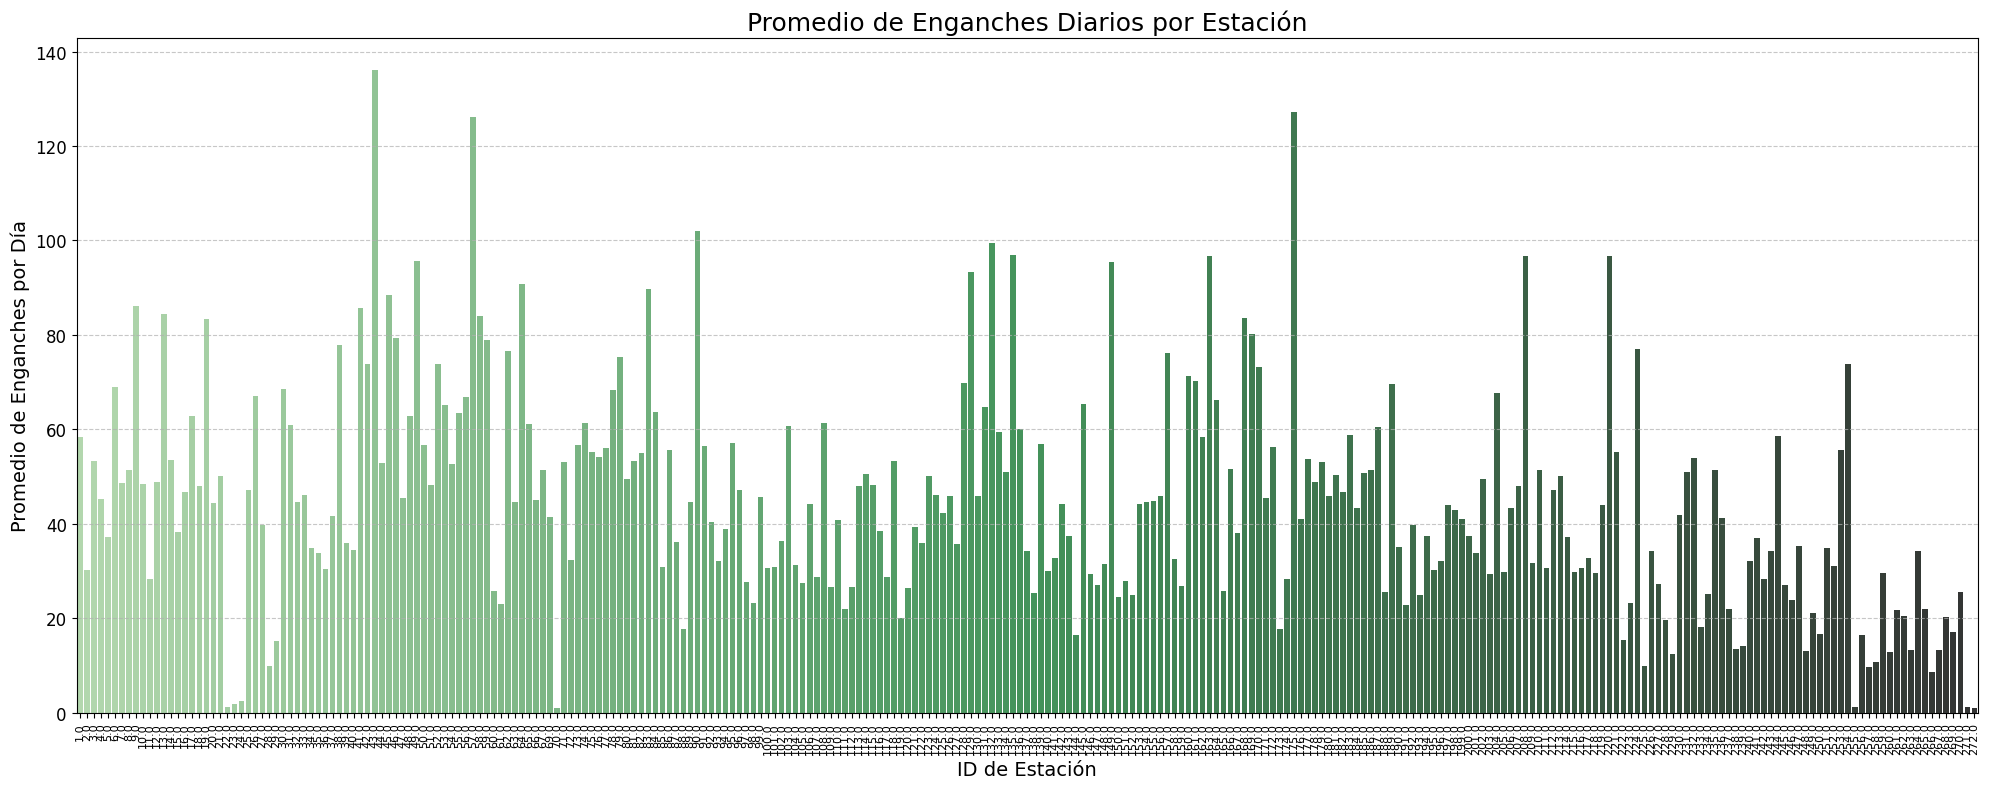


Gráfica de Promedio de Enganches Diarios por Estación generada.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- BLOQUE DE CARGA Y PREPROCESAMIENTO OBLIGATORIO DE 'basedatos_df' ---
# Este bloque se ejecutará SIEMPRE para asegurar que 'basedatos_df' y 'plug_hourTime'
# estén listos y correctos antes de intentar generar la gráfica.

try:
    # 1. Cargar el dataset original
    df_raw = pd.read_csv('bdcompleta_usos_bicimad.csv')
    print("Dataset 'bdcompleta_usos_bicimad.csv' cargado para preprocesamiento.")

    # 2. Convertir 'unplug_hourTime' a formato datetime
    df_raw['unplug_hourTime'] = pd.to_datetime(df_raw['unplug_hourTime'], errors='coerce')
    df_raw.dropna(subset=['unplug_hourTime'], inplace=True) # Eliminar filas con fechas no válidas

    # 3. Asegurarse de que 'travel_time' es numérico y manejar valores nulos
    df_raw['travel_time'] = pd.to_numeric(df_raw['travel_time'], errors='coerce')
    df_raw.dropna(subset=['travel_time'], inplace=True) # Eliminar filas donde travel_time sea NaN

    # Crear una copia para 'basedatos_df'
    basedatos_df = df_raw.copy()
    
    # 4. Aplicar las reglas específicas de filtrado y ajuste del travel_time:
    #    a. Eliminar registros si el tiempo de viaje es mayor a 24 horas (en segundos)
    basedatos_df = basedatos_df[basedatos_df['travel_time'] <= (24 * 3600)].copy()

    #    b. Si el tiempo de viaje está entre 2 y 24 horas, ajustarlo a 2 horas (7200 segundos)
    long_travels_mask = (basedatos_df['travel_time'] > (2 * 3600)) & \
                        (basedatos_df['travel_time'] <= (24 * 3600))
    basedatos_df.loc[long_travels_mask, 'travel_time'] = (2 * 3600)

    # 5. Recalcular 'plug_hourTime' con los 'travel_time' posiblemente ajustados
    basedatos_df['plug_hourTime'] = basedatos_df['unplug_hourTime'] + \
                                    pd.to_timedelta(basedatos_df['travel_time'], unit='s')

    # 6. Filtrar IDs de estación no válidos (0 o > 272)
    basedatos_df = basedatos_df[
        ((basedatos_df['idunplug_station'] > 0) & (basedatos_df['idunplug_station'] <= 272)) &
        ((basedatos_df['idplug_station'] > 0) & (basedatos_df['idplug_station'] <= 272))
    ].copy()

    print("`basedatos_df` ha sido preprocesado y está listo con 'plug_hourTime' y filtros aplicados.")

except FileNotFoundError:
    print("ERROR FATAL: El archivo 'bdcompleta_usos_bicimad.csv' no se encuentra.")
    print("Asegúrate de que el archivo está en la misma carpeta que tu script o notebook.")
    exit() # Detiene el script si el archivo no existe
except KeyError as e:
    print(f"ERROR FATAL: Columna no encontrada: {e}.")
    print("Verifica que tu archivo CSV contiene exactamente las columnas 'unplug_hourTime', 'travel_time', 'idunplug_station', 'idplug_station'.")
    # Para depuración, imprime las columnas disponibles si se pudo cargar el archivo
    if 'df_raw' in locals():
        print("Columnas disponibles después de la carga inicial:", df_raw.columns.tolist())
    exit() # Detiene el script si hay un error de columna
except Exception as e:
    print(f"ERROR FATAL: Ocurrió un problema inesperado durante el preprocesamiento: {e}")
    exit() # Detiene el script por cualquier otro error

# --- FIN BLOQUE DE CARGA Y PREPROCESAMIENTO ---


# --- CÓDIGO PARA LA GRÁFICA DE "Promedio de Enganches Diarios por Estación" ---
print("\nGenerando gráfica de Promedio de Enganches Diarios por Estación...")

# 1. Calcular Enganches por Día por Estación
df_daily_plug = basedatos_df.copy()

# 'plug_hourTime' ya debería estar en el formato correcto por el preprocesamiento anterior,
# pero esta línea es una última comprobación de seguridad.
if not pd.api.types.is_datetime64_any_dtype(df_daily_plug['plug_hourTime']):
    df_daily_plug['plug_hourTime'] = pd.to_datetime(df_daily_plug['plug_hourTime'])

df_daily_plug['date'] = df_daily_plug['plug_hourTime'].dt.date

# No es necesario filtrar de nuevo las estaciones aquí si ya se hizo al crear basedatos_df.
# Si el filtrado de basedatos_df incluye estaciones de desenganche, esta línea asegura
# que solo se consideren las de enganche válidas para esta agrupación.
df_daily_plug = df_daily_plug[(df_daily_plug['idplug_station'] > 0) & (df_daily_plug['idplug_station'] <= 272)]

# Agrupar por estación de enganche y fecha para obtener el total de enganches por día por estación
daily_station_plug_counts = df_daily_plug.groupby(['idplug_station', 'date']).size().reset_index(name='daily_plug_count')

# 2. Calcular el Promedio Diario de Enganches por Estación
avg_daily_plug_per_station = daily_station_plug_counts.groupby('idplug_station')['daily_plug_count'].mean().reset_index()

# Ordenar las estaciones por su promedio de enganches (de mayor a menor)
avg_daily_plug_per_station = avg_daily_plug_per_station.sort_values(by='daily_plug_count', ascending=False)

print("Las 10 estaciones con mayor promedio de enganches diarios:")
print(avg_daily_plug_per_station.head(10))

# 3. Generar el Gráfico de Barras
plt.figure(figsize=(20, 8)) # Ajustar el tamaño de la figura para mejor visualización
sns.barplot(
    x='idplug_station',
    y='daily_plug_count',
    data=avg_daily_plug_per_station,
    palette='Greens_d' # Esquema de color para las barras
)

plt.title('Promedio de Enganches Diarios por Estación', fontsize=18)
plt.xlabel('ID de Estación', fontsize=14)
plt.ylabel('Promedio de Enganches por Día', fontsize=14)
plt.xticks(rotation=90, fontsize=8) # Rotar etiquetas del eje X si hay muchas estaciones
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) # Añadir rejilla solo en el eje Y
plt.tight_layout() # Ajustar el diseño para evitar que las etiquetas se corten
plt.show()

print("\nGráfica de Promedio de Enganches Diarios por Estación generada.")

Dataset 'bdcompleta_usos_bicimad.csv' cargado para preprocesamiento.
`basedatos_df` ha sido preprocesado y está listo con 'plug_hourTime' y filtros aplicados.

--- Promedio de Desenganches Diarios por Estación (Todas las estaciones) ---

--- Estaciones MÁS IMPORTANTES (Promedio de desenganches/día > 80): 21 estaciones ---
     idunplug_station  daily_unplug_count
42                 43          133.964799
56                 57          126.873160
174               175          125.726829
89                 90          102.855944
162               163           95.621075
148               149           95.527894
207               208           95.496683
131               132           95.169220
48                 49           95.042046
134               135           93.557814
128               129           91.135889
219               220           90.456816
63                 64           89.370035
82                 83           88.682041
44                 45           87.925117
8   

C:\Users\ProjectSupport\AppData\Local\Temp\ipykernel_18808\982323087.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


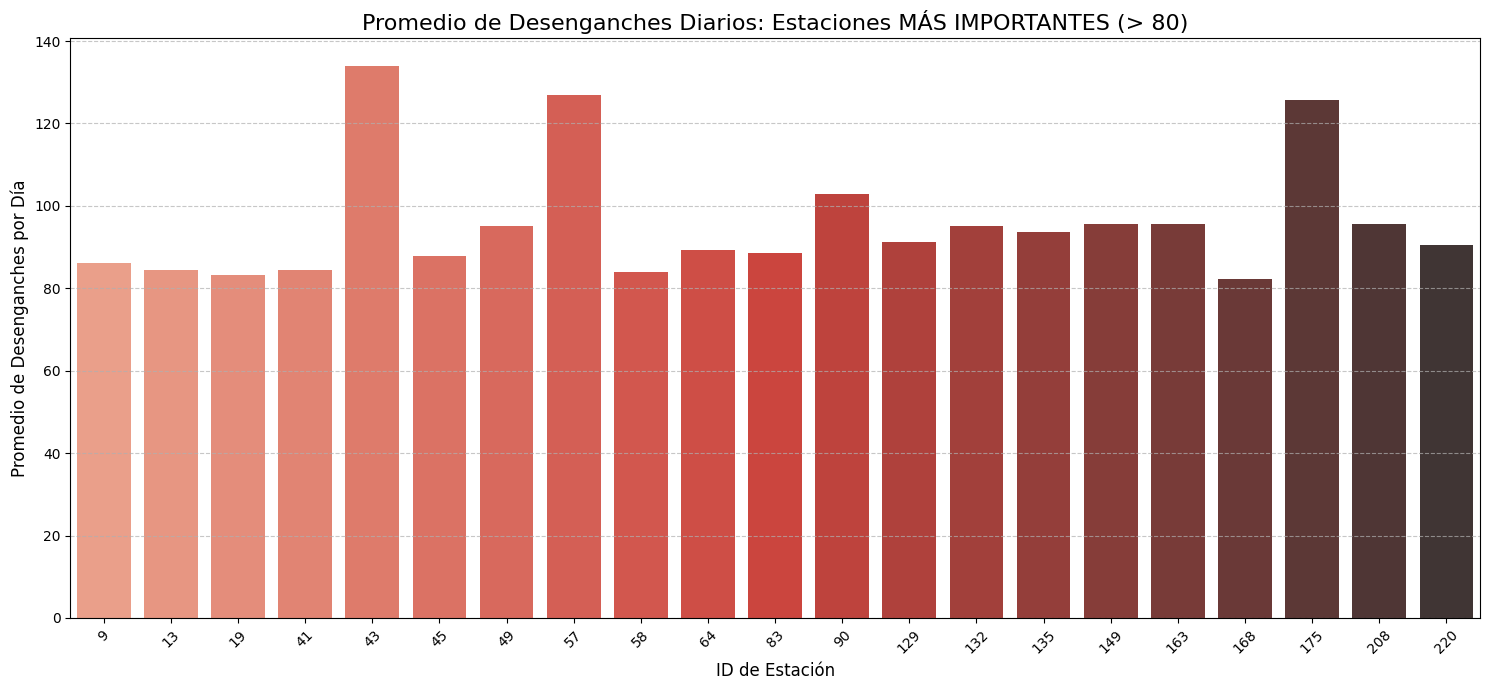

C:\Users\ProjectSupport\AppData\Local\Temp\ipykernel_18808\982323087.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


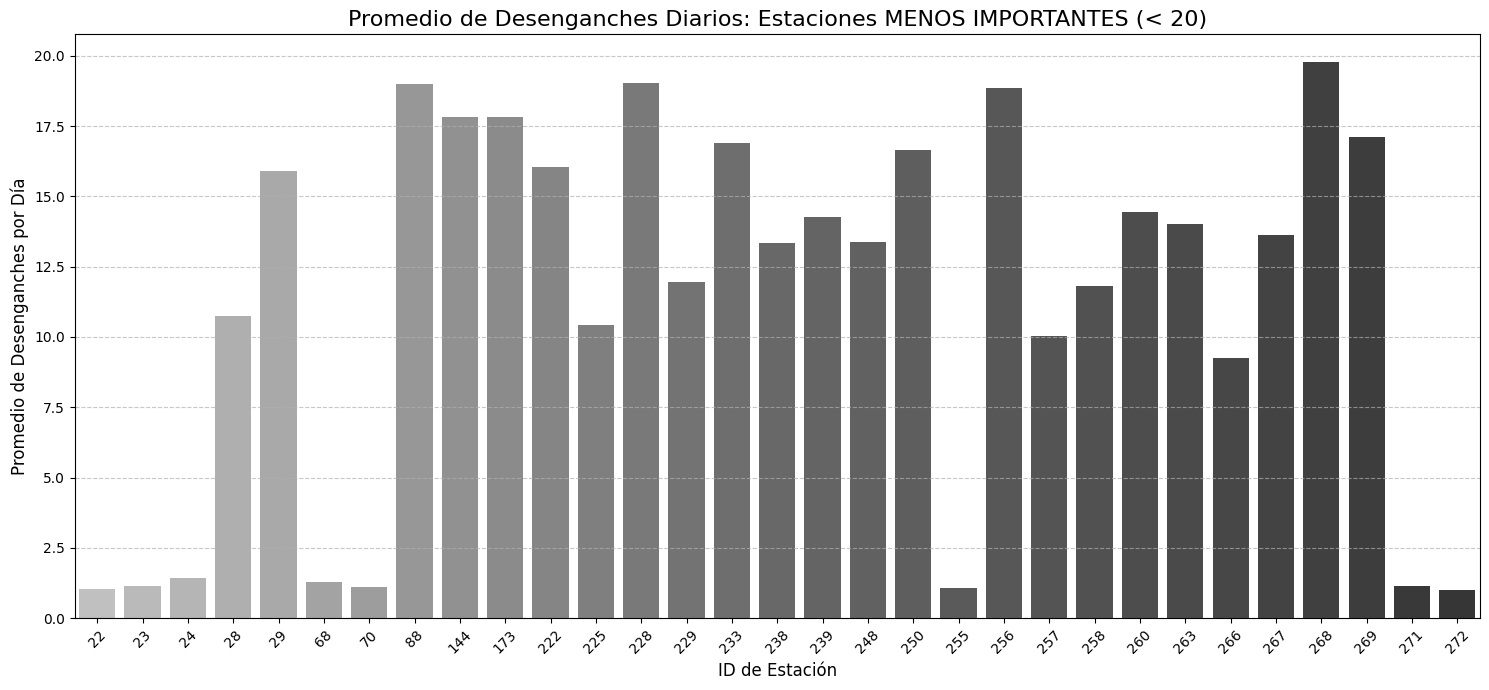


Análisis de estaciones importantes y menos importantes completado.


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- BLOQUE DE CARGA Y PREPROCESAMIENTO OBLIGATORIO DE 'basedatos_df' ---
# Este bloque se ejecutará SIEMPRE para asegurar que 'basedatos_df' y 'plug_hourTime'
# estén listos y correctos antes de intentar generar la gráfica.

try:
    # 1. Cargar el dataset original
    df_raw = pd.read_csv('bdcompleta_usos_bicimad.csv')
    print("Dataset 'bdcompleta_usos_bicimad.csv' cargado para preprocesamiento.")

    # 2. Convertir 'unplug_hourTime' a formato datetime
    df_raw['unplug_hourTime'] = pd.to_datetime(df_raw['unplug_hourTime'], errors='coerce')
    df_raw.dropna(subset=['unplug_hourTime'], inplace=True) # Eliminar filas con fechas no válidas

    # 3. Asegurarse de que 'travel_time' es numérico y manejar valores nulos
    df_raw['travel_time'] = pd.to_numeric(df_raw['travel_time'], errors='coerce')
    df_raw.dropna(subset=['travel_time'], inplace=True) # Eliminar filas donde travel_time sea NaN

    # Crear una copia para 'basedatos_df'
    basedatos_df = df_raw.copy()

    # 4. Aplicar las reglas específicas de filtrado y ajuste del travel_time:
    #    a. Eliminar registros si el tiempo de viaje es mayor a 24 horas (en segundos)
    basedatos_df = basedatos_df[basedatos_df['travel_time'] <= (24 * 3600)].copy()

    #    b. Si el tiempo de viaje está entre 2 y 24 horas, ajustarlo a 2 horas (7200 segundos)
    long_travels_mask = (basedatos_df['travel_time'] > (2 * 3600)) & \
                        (basedatos_df['travel_time'] <= (24 * 3600))
    basedatos_df.loc[long_travels_mask, 'travel_time'] = (2 * 3600)

    # 5. Recalcular 'plug_hourTime' con los 'travel_time' posiblemente ajustados
    basedatos_df['plug_hourTime'] = basedatos_df['unplug_hourTime'] + \
                                    pd.to_timedelta(basedatos_df['travel_time'], unit='s')

    # 6. Filtrar IDs de estación no válidos (0 o > 272)
    basedatos_df = basedatos_df[
        ((basedatos_df['idunplug_station'] > 0) & (basedatos_df['idunplug_station'] <= 272)) &
        ((basedatos_df['idplug_station'] > 0) & (basedatos_df['idplug_station'] <= 272))
    ].copy()

    print("`basedatos_df` ha sido preprocesado y está listo con 'plug_hourTime' y filtros aplicados.")

except FileNotFoundError:
    print("ERROR FATAL: El archivo 'bdcompleta_usos_bicimad.csv' no se encuentra.")
    print("Asegúrate de que el archivo está en la misma carpeta que tu script o notebook.")
    exit()
except KeyError as e:
    print(f"ERROR FATAL: Columna no encontrada: {e}.")
    print("Verifica que tu archivo CSV contiene exactamente las columnas 'unplug_hourTime', 'travel_time', 'idunplug_station', 'idplug_station'.")
    if 'df_raw' in locals():
        print("Columnas disponibles después de la carga inicial:", df_raw.columns.tolist())
    exit()
except Exception as e:
    print(f"ERROR FATAL: Ocurrió un problema inesperado durante el preprocesamiento: {e}")
    exit()

# --- FIN BLOQUE DE CARGA Y PREPROCESAMIENTO ---


# --- CÓDIGO PARA CALCULAR Y FILTRAR ESTACIONES DE DESENGANCHE ---

# 1. Calcular Desenganches por Día por Estación
df_daily_unplug = basedatos_df.copy()

# Asegurarse de que 'unplug_hourTime' es un tipo de dato datetime (comprobación de seguridad)
if not pd.api.types.is_datetime64_any_dtype(df_daily_unplug['unplug_hourTime']):
    df_daily_unplug['unplug_hourTime'] = pd.to_datetime(df_daily_unplug['unplug_hourTime'])

df_daily_unplug['date'] = df_daily_unplug['unplug_hourTime'].dt.date

# Filtra las estaciones de desenganche no válidas (0 o > 272)
df_daily_unplug = df_daily_unplug[(df_daily_unplug['idunplug_station'] > 0) & (df_daily_unplug['idunplug_station'] <= 272)]

# Agrupar por estación de desenganche y fecha para obtener el total de desenganches por día por estación
daily_station_unplug_counts = df_daily_unplug.groupby(['idunplug_station', 'date']).size().reset_index(name='daily_unplug_count')

# 2. Calcular el Promedio Diario de Desenganches por Estación
avg_daily_unplug_per_station = daily_station_unplug_counts.groupby('idunplug_station')['daily_unplug_count'].mean().reset_index()

# Opcional: Ordenar las estaciones por su promedio de desenganches (de mayor a menor)
avg_daily_unplug_per_station = avg_daily_unplug_per_station.sort_values(by='daily_unplug_count', ascending=False)

print("\n--- Promedio de Desenganches Diarios por Estación (Todas las estaciones) ---")
# print(avg_daily_unplug_per_station.head()) # Puedes imprimir el head completo si quieres

# --- FILTRAR ESTACIONES IMPORTANTES Y MENOS IMPORTANTES ---

# Estaciones más importantes (promedio de desenganches diarios > 80)
most_important_stations = avg_daily_unplug_per_station[avg_daily_unplug_per_station['daily_unplug_count'] > 80]
print(f"\n--- Estaciones MÁS IMPORTANTES (Promedio de desenganches/día > 80): {len(most_important_stations)} estaciones ---")
print(most_important_stations)

# Estaciones menos importantes (promedio de desenganches diarios < 20)
less_important_stations = avg_daily_unplug_per_station[avg_daily_unplug_per_station['daily_unplug_count'] < 20]
print(f"\n--- Estaciones MENOS IMPORTANTES (Promedio de desenganches/día < 20): {len(less_important_stations)} estaciones ---")
print(less_important_stations)

# --- FIN CÓDIGO DE FILTRADO ---


# --- OPCIONAL: Generar una gráfica solo con las estaciones más importantes ---
if not most_important_stations.empty:
    plt.figure(figsize=(15, 7))
    sns.barplot(
        x='idunplug_station',
        y='daily_unplug_count',
        data=most_important_stations,
        palette='Reds_d' # Un esquema de color para destacar
    )
    plt.title('Promedio de Desenganches Diarios: Estaciones MÁS IMPORTANTES (> 80)', fontsize=16)
    plt.xlabel('ID de Estación', fontsize=12)
    plt.ylabel('Promedio de Desenganches por Día', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo hay estaciones con un promedio de desenganches diarios superior a 80.")

# --- OPCIONAL: Generar una gráfica solo con las estaciones menos importantes ---
if not less_important_stations.empty:
    plt.figure(figsize=(15, 7))
    sns.barplot(
        x='idunplug_station',
        y='daily_unplug_count',
        data=less_important_stations,
        palette='Greys_d' # Un esquema de color para las menos activas
    )
    plt.title('Promedio de Desenganches Diarios: Estaciones MENOS IMPORTANTES (< 20)', fontsize=16)
    plt.xlabel('ID de Estación', fontsize=12)
    plt.ylabel('Promedio de Desenganches por Día', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo hay estaciones con un promedio de desenganches diarios inferior a 20.")

print("\nAnálisis de estaciones importantes y menos importantes completado.")

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- BLOQUE DE CARGA Y PREPROCESAMIENTO OBLIGATORIO DE 'basedatos_df' ---
# Este bloque se ejecutará SIEMPRE para asegurar que 'basedatos_df' esté listo
# con datos limpios, columnas de tiempo y nombres de estación mapeados.

try:
    print("--- INICIANDO CARGA Y PREPROCESAMIENTO DE DATOS ---")
    # 1. Cargar el dataset principal de usos de bicicletas
    # ¡Si el error 'Error tokenizing data' persiste, DEBES CORREGIR MANUALMENTE TU CSV!
    df_raw = pd.read_csv('bdcompleta_usos_bicimad.csv')
    print("✅ Dataset 'bdcompleta_usos_bicimad.csv' cargado.")

    # 2. Cargar el dataset de estaciones para mapeo de nombres
    df_stations = pd.read_csv('estaciones_bicimad.csv')
    # Limitar estaciones hasta el ID 269, como solicitaste
    df_stations = df_stations[df_stations['id'] <= 269].copy()
    # Crear un diccionario de mapeo de ID a Nombre
    station_id_to_name = dict(zip(df_stations['id'], df_stations['name']))
    print(f"✅ Dataset 'estaciones_bicimad.csv' cargado y filtrado (hasta ID 269). Mapeo de {len(station_id_to_name)} estaciones.")

    # 3. Convertir 'unplug_hourTime' a formato datetime
    df_raw['unplug_hourTime'] = pd.to_datetime(df_raw['unplug_hourTime'], errors='coerce')
    df_raw.dropna(subset=['unplug_hourTime'], inplace=True) # Eliminar filas con fechas no válidas

    # 4. Asegurarse de que 'travel_time' es numérico y manejar valores nulos
    df_raw['travel_time'] = pd.to_numeric(df_raw['travel_time'], errors='coerce')
    df_raw.dropna(subset=['travel_time'], inplace=True) # Eliminar filas donde travel_time sea NaN

    # Crear una copia para 'basedatos_df'
    basedatos_df = df_raw.copy()

    # 5. Aplicar las reglas específicas de filtrado y ajuste del travel_time:
    basedatos_df = basedatos_df[basedatos_df['travel_time'] <= (24 * 3600)].copy()
    long_travels_mask = (basedatos_df['travel_time'] > (2 * 3600)) & \
                        (basedatos_df['travel_time'] <= (24 * 3600))
    basedatos_df.loc[long_travels_mask, 'travel_time'] = (2 * 3600)

    # 6. Recalcular 'plug_hourTime' con los 'travel_time' posiblemente ajustados
    basedatos_df['plug_hourTime'] = basedatos_df['unplug_hourTime'] + \
                                    pd.to_timedelta(basedatos_df['travel_time'], unit='s')

    # 7. Filtrar IDs de estación válidos (0 < ID <= 269) para ambas columnas
    # Usamos valid_station_ids de df_stations filtrado previamente
    valid_station_ids_list = df_stations['id'].tolist()
    basedatos_df = basedatos_df[
        (basedatos_df['idunplug_station'].isin(valid_station_ids_list)) &
        (basedatos_df['idplug_station'].isin(valid_station_ids_list))
    ].copy()

    # 8. Mapear IDs a nombres de estación en basedatos_df
    basedatos_df['unplug_station_name'] = basedatos_df['idunplug_station'].map(station_id_to_name)
    basedatos_df['plug_station_name'] = basedatos_df['idplug_station'].map(station_id_to_name)

    # Eliminar filas donde el mapeo no encontró un nombre (si hay IDs en los datos de uso que no están en estaciones_bicimad.csv)
    basedatos_df.dropna(subset=['unplug_station_name', 'plug_station_name'], inplace=True)

    print("✅ `basedatos_df` ha sido preprocesado, filtrado y nombres de estación mapeados.")

except FileNotFoundError as e:
    print(f"❌ ERROR FATAL: Archivo no encontrado. Asegúrate de tener 'bdcompleta_usos_bicimad.csv' y 'estaciones_bicimad.csv' en la misma carpeta. Detalle: {e}")
    raise # Relanza la excepción para detener la ejecución
except KeyError as e:
    print(f"❌ ERROR FATAL: Columna no encontrada: {e}.")
    print("Verifica que tus archivos CSV contienen exactamente las columnas esperadas (por ejemplo: 'unplug_hourTime', 'travel_time', 'idunplug_station', 'idplug_station' en 'bdcompleta_usos_bicimad.csv', y 'id', 'name' en 'estaciones_bicimad.csv').")
    if 'df_raw' in locals():
        print("Columnas disponibles en 'bdcompleta_usos_bicimad.csv':", df_raw.columns.tolist())
    if 'df_stations' in locals():
        print("Columnas disponibles en 'estaciones_bicimad.csv':", df_stations.columns.tolist())
    raise # Relanza la excepción
except pd.errors.ParserError as e:
    print(f"❌ ERROR FATAL EN EL CSV: Error de formato de datos al cargar 'bdcompleta_usos_bicimad.csv'. Detalle: {e}")
    print("¡Esto es clave! Significa que una línea en tu CSV no tiene el número esperado de columnas. Revisa la línea indicada en el error (ej. 'line 23').")
    raise # Relanza la excepción
except Exception as e:
    print(f"❌ ERROR FATAL: Ocurrió un problema inesperado durante el preprocesamiento: {e}")
    raise # Relanza la excepción

# --- FIN BLOQUE DE CARGA Y PREPROCESAMIENTO ---

# --- FUNCIONES PARA GENERAR GRÁFICAS DE ESTACIONES ---

def plot_station_activity(df, station_type, threshold_high, threshold_low, title_prefix, color_high, color_low):
    """
    Genera y muestra gráficas para estaciones más/menos activas y todas (opcionalmente).

    Args:
        df (pd.DataFrame): DataFrame con conteos diarios por estación (ej. daily_station_unplug_counts).
        station_type (str): 'unplug' o 'plug' para el tipo de estación (para nombres de columna).
        threshold_high (int): Umbral para estaciones "más importantes".
        threshold_low (int): Umbral para estaciones "menos importantes".
        title_prefix (str): Prefijo para los títulos de las gráficas (ej. 'Desenganches').
        color_high (str): Paleta de colores para estaciones importantes.
        color_low (str): Paleta de colores para estaciones menos importantes.
    """
    station_name_col = f'{station_type}_station_name'
    daily_count_col = f'daily_{station_type}_count'

    # Calcular el promedio diario de actividad por estación
    avg_daily_activity_per_station = df.groupby(station_name_col)[daily_count_col].mean().reset_index()
    avg_daily_activity_per_station = avg_daily_activity_per_station.sort_values(by=daily_count_col, ascending=False)

    print(f"\n--- Promedio de {title_prefix} Diarios por Estación (Top 10) ---")
    print(avg_daily_activity_per_station.head(10))

    # --- Gráfica 1: Todas las estaciones (condicionalmente) ---
    if len(avg_daily_activity_per_station) < 50: # Umbral para evitar gráficos ilegibles
        plt.figure(figsize=(20, 8))
        sns.barplot(
            x=station_name_col,
            y=daily_count_col,
            data=avg_daily_activity_per_station,
            palette='viridis' if station_type == 'unplug' else 'plasma'
        )
        plt.title(f'Promedio de {title_prefix} Diarios por Estación (Todas)', fontsize=18)
        plt.xlabel('Nombre de Estación', fontsize=14)
        plt.ylabel(f'Promedio de {title_prefix} por Día', fontsize=14)
        plt.xticks(rotation=90, fontsize=8)
        plt.yticks(fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n--- {title_prefix} Diarios por Estación (TODAS): Demasiadas para graficar ({len(avg_daily_activity_per_station)}). Puedes ver los datos resumidos arriba. ---")

    # Filtrar estaciones más y menos importantes
    most_important_stations = avg_daily_activity_per_station[avg_daily_activity_per_station[daily_count_col] > threshold_high]
    less_important_stations = avg_daily_activity_per_station[avg_daily_activity_per_station[daily_count_col] < threshold_low]

    # --- Gráfica 2: Estaciones más importantes ---
    if not most_important_stations.empty:
        plt.figure(figsize=(15, 7))
        sns.barplot(
            x=station_name_col,
            y=daily_count_col,
            data=most_important_stations,
            palette=color_high
        )
        plt.title(f'Promedio de {title_prefix} Diarios: Estaciones MÁS IMPORTANTES (> {threshold_high})', fontsize=16)
        plt.xlabel('Nombre de Estación', fontsize=12)
        plt.ylabel(f'Promedio de {title_prefix} por Día', fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        print(f"\nEstaciones MÁS IMPORTANTES ({title_prefix}, promedio > {threshold_high}):")
        print(most_important_stations)
    else:
        print(f"\nNo se encontraron estaciones con un promedio de {title_prefix.lower()} diarios superior a {threshold_high}.")

    # --- Gráfica 3: Estaciones menos importantes ---
    if not less_important_stations.empty:
        plt.figure(figsize=(15, 7))
        sns.barplot(
            x=station_name_col,
            y=daily_count_col,
            data=less_important_stations,
            palette=color_low
        )
        plt.title(f'Promedio de {title_prefix} Diarios: Estaciones MENOS IMPORTANTES (< {threshold_low})', fontsize=16)
        plt.xlabel('Nombre de Estación', fontsize=12)
        plt.ylabel(f'Promedio de {title_prefix} por Día', fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        print(f"\nEstaciones MENOS IMPORTANTES ({title_prefix}, promedio < {threshold_low}):")
        print(less_important_stations)
    else:
        print(f"\nNo se encontraron estaciones con un promedio de {title_prefix.lower()} diarios inferior a {threshold_low}.")

# --- EJECUCIÓN PARA DESENGANCHES ---
print("\n--- INICIANDO ANÁLISIS Y GRÁFICAS DE DESENGANCHES ---")
# Asegurarse de que 'unplug_hourTime' es un tipo de dato datetime (comprobación de seguridad)
# y que 'unplug_station_name' existe en basedatos_df
if 'basedatos_df' in locals() and 'unplug_station_name' in basedatos_df.columns:
    df_daily_unplug = basedatos_df.copy()
    df_daily_unplug['date'] = df_daily_unplug['unplug_hourTime'].dt.date
    
    # Agrupar por nombre de estación y fecha para obtener el total de desenganches por día por estación
    daily_station_unplug_counts = df_daily_unplug.groupby(['unplug_station_name', 'date']).size().reset_index(name='daily_unplug_count')

    plot_station_activity(
        df=daily_station_unplug_counts,
        station_type='unplug',
        threshold_high=80,
        threshold_low=20,
        title_prefix='Desenganches',
        color_high='Reds_d',
        color_low='Greys_d'
    )
    print("\n--- ANÁLISIS Y GRÁFICAS DE DESENGANCHES COMPLETADO ---")
else:
    print("❌ No se pudo ejecutar el análisis de desenganches. 'basedatos_df' o 'unplug_station_name' no están disponibles. Revisa los errores anteriores.")

# --- EJECUCIÓN PARA ENGANCHES ---
print("\n--- INICIANDO ANÁLISIS Y GRÁFICAS DE ENGANCHES ---")
if 'basedatos_df' in locals() and 'plug_station_name' in basedatos_df.columns:
    df_daily_plug = basedatos_df.copy()
    df_daily_plug['date'] = df_daily_plug['plug_hourTime'].dt.date

    # Agrupar por nombre de estación y fecha para obtener el total de enganches por día por estación
    daily_station_plug_counts = df_daily_plug.groupby(['plug_station_name', 'date']).size().reset_index(name='daily_plug_count')

    plot_station_activity(
        df=daily_station_plug_counts,
        station_type='plug',
        threshold_high=80,
        threshold_low=20,
        title_prefix='Enganches',
        color_high='Greens_d',
        color_low='Purples_d'
    )
    print("\n--- ANÁLISIS Y GRÁFICAS DE ENGANCHES COMPLETADO ---")
else:
    print("❌ No se pudo ejecutar el análisis de enganches. 'basedatos_df' o 'plug_station_name' no están disponibles. Revisa los errores anteriores.")

--- INICIANDO CARGA Y PREPROCESAMIENTO DE DATOS ---
✅ Dataset 'bdcompleta_usos_bicimad.csv' cargado.
❌ ERROR FATAL EN EL CSV: Error de formato de datos al cargar 'bdcompleta_usos_bicimad.csv'. Detalle: Error tokenizing data. C error: Expected 5 fields in line 23, saw 6

¡Esto es clave! Significa que una línea en tu CSV no tiene el número esperado de columnas. Revisa la línea indicada en el error (ej. 'line 23').


ParserError: Error tokenizing data. C error: Expected 5 fields in line 23, saw 6


C:\Users\ProjectSupport\AppData\Local\Temp\ipykernel_23956\1898687545.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dia_semana_nombre', y='cant_plug_hora', data=weekly_avg_plug, palette='viridis')


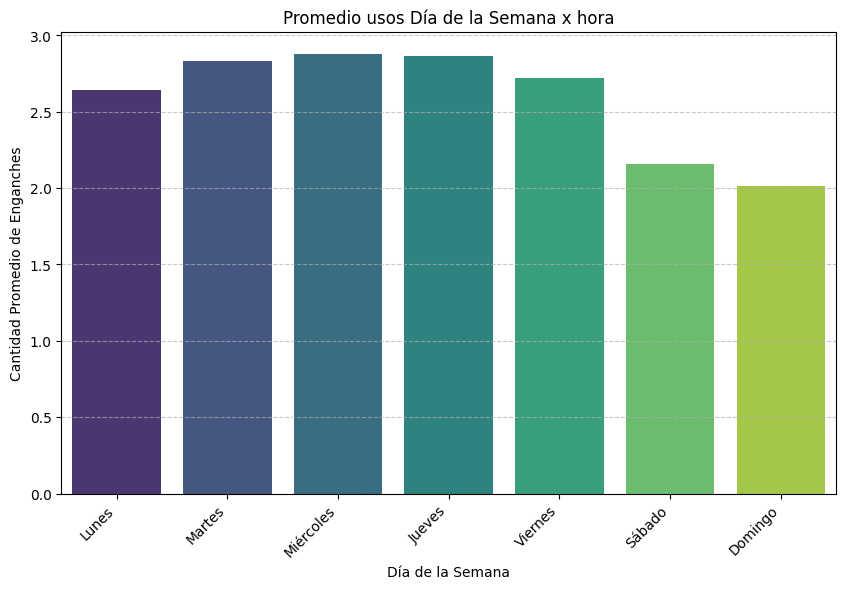

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegúrate de que basedatos_df está cargado

# Opcional: Mapear números de día a nombres para mejor visualización
day_names = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
# Crea una copia para no modificar basedatos_df directamente si no quieres
temp_df = basedatos_df.copy()
temp_df['dia_semana_nombre'] = temp_df['dia_semana'].map(lambda x: day_names[x])

# Agrupar por día de la semana y calcular la media de cant_plug_hora
weekly_avg_plug = temp_df.groupby('dia_semana_nombre')['cant_plug_hora'].mean().reset_index()

# Asegurar el orden correcto de los días de la semana
weekly_avg_plug['dia_semana_orden'] = weekly_avg_plug['dia_semana_nombre'].map({name: i for i, name in enumerate(day_names)})
weekly_avg_plug = weekly_avg_plug.sort_values('dia_semana_orden')

plt.figure(figsize=(10, 6))
sns.barplot(x='dia_semana_nombre', y='cant_plug_hora', data=weekly_avg_plug, palette='viridis')
plt.title('Promedio usos Día de la Semana x hora')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad Promedio de Enganches')
plt.xticks(rotation=45, ha='right') # Rotar etiquetas para mejor lectura
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Promedio de Enganches por Mes del Año.

### Impacto de Días Especiales

C:\Users\ProjectSupport\AppData\Local\Temp\ipykernel_7912\3877337467.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='dia_especial', y='cant_plug_hora', data=special_day_avg_plug, palette='coolwarm')


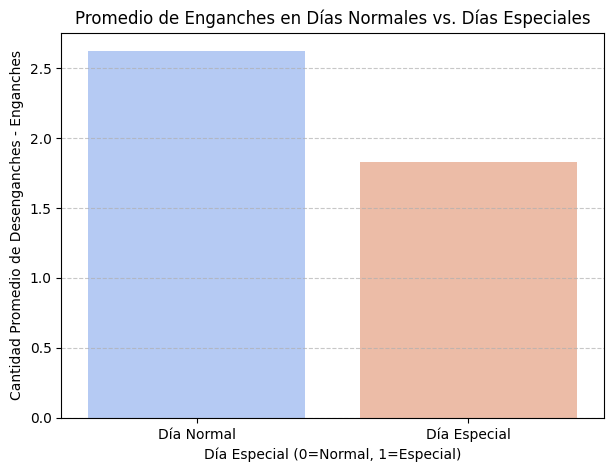

In [4]:

# Agrupar por dia_especial y calcular la media de cant_plug_hora
special_day_avg_plug = basedatos_df.groupby('dia_especial')['cant_plug_hora'].mean().reset_index()

plt.figure(figsize=(7, 5))
sns.barplot(x='dia_especial', y='cant_plug_hora', data=special_day_avg_plug, palette='coolwarm')
plt.title('Promedio de Enganches en Días Normales vs. Días Especiales')
plt.xlabel('Día Especial (0=Normal, 1=Especial)')
plt.ylabel('Cantidad Promedio de Desenganches - Enganches')
plt.xticks(ticks=[0, 1], labels=['Día Normal', 'Día Especial'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()